In [439]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [440]:
%matplotlib inline

from __future__ import annotations
from haversine import haversine, Unit
import pandas as pd
import csv
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import math
import pandas as pd

# 1. Cleanup

### Data before cleanup:

In [441]:
pd.read_csv('./data/DataSample.csv')

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730
...,...,...,...,...,...,...,...
22020,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560
22021,5614888,2017-06-21 08:23:01.793,CA,AB,Calgary,51.02093,-114.10621
22022,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220
22023,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260


#### Place the data into a dictionary to filter it for duplicates

In [442]:
def filter_data(file: str) -> dict[str, list]:
    """Returns a dictionary of the data with the suspicious entries filtered out"""
    raw_data = pd.read_csv(file)
    seen = {}
    
    for index, row in raw_data.iterrows():
        formatted = f'{row[" TimeSt"]}, {row["Latitude"]} {row["Longitude"]}'
        
        if formatted in seen:
            seen[formatted] = []
        else:
            seen.setdefault(formatted, []).append(row)
    return seen

#### After filtering the data, write it to a new file

In [443]:
def cleanup(file: str) -> None:
    """Filter the data from <file> and write it to a new file"""
    filtered_data = filter_data(file)
    
    with open('./data/FilteredDataSample.csv', 'w') as f:
        csv_writer = csv.writer(f)
        header = ['_ID', ' TimeSt', 'Country', 'Province', 'City', 'Latitude', 'Longitude']
        csv_writer.writerow(header)
        
        for key in filtered_data:
            if filtered_data[key]:
                csv_writer.writerows(filtered_data[key])

In [444]:
cleanup('./data/DataSample.csv')

### Data after cleanup:

In [445]:
pd.read_csv('./data/FilteredDataSample.csv')

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730
...,...,...,...,...,...,...,...
17968,5614689,2017-06-21 13:23:01.370,CA,ON,London,42.96110,-81.24310
17969,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560
17970,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220
17971,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260


# 2. Label

In [446]:
def get_poi_data(file: str) -> list[dict]:
    """Returns the list of POIs with their information"""
    raw_data = pd.read_csv(file)
    poi_list = []
    
    for index, row in raw_data.iterrows():
        poi_list.append({'id': row['POIID'], 'lat': row[' Latitude'], 'lon': row['Longitude']})
    return poi_list


def get_closest_poi(request, poi_list: list[dict]) -> tuple[dict, float]:
    """Returns the closest POI and its distance to <request>"""
    # Temporarily set closest POI and distance to a large value
    closest_poi = poi_list[0]
    closest_distance = 1000000 # No distance will be greater than this
    request_coords = (request['Latitude'], request['Longitude'])

    for poi in poi_list:
            poi_coords = (poi['lat'], poi['lon'])
            distance = haversine(request_coords, poi_coords)
            
            if distance < closest_distance:
                closest_poi = poi
                closest_distance = distance
    return (closest_poi, closest_distance)
    
    
def label(file: str) -> None:
    """Assign each request from <file> to it's closest POI"""
    poi_list = get_poi_data('./data/POIList.csv')
    
    df = pd.read_csv(file)
    closest_poi_list = []
    poi_distances = []
    
    for index, row in df.iterrows():
        closest_info = get_closest_poi(row, poi_list)
        closest_poi_list.append(closest_info[0]['id'])
        poi_distances.append(closest_info[1])
        

    
    # Add column indicating the id of the closest POI
    df['ClosestPOI'] = closest_poi_list
    df['POIDistance'] = poi_distances
    df.to_csv('./data/FilteredDataSample.csv')
        

In [447]:
label('./data/FilteredDataSample.csv')

### After labeling:

In [448]:
pd.read_csv('./data/FilteredDataSample.csv').sort_values('POIDistance').tail(20)

,Unnamed: 0,_ID,TimeSt,Country,Province,City,Latitude,Longitude,ClosestPOI,POIDistance
3826,3826,4748303,2017-06-21 19:15:09.123,CA,YT,Pelly Crossing,62.82730,-136.53957,POI1,1684.759911
11425,11425,5215632,2017-06-21 05:49:04.917,CA,ON,Toronto,51.29930,9.49100,POI4,5201.826254
13991,13991,5373264,2017-06-21 02:00:23.357,CA,ON,Toronto,48.73082,9.24356,POI4,5300.328921
16162,16162,5502522,2017-06-21 11:13:17.887,CA,ON,Toronto,35.77552,51.32807,POI4,8870.797842
14713,14713,5416473,2017-06-21 01:04:29.657,CA,ON,Toronto,35.77532,51.32877,POI4,8870.855830
12123,12123,5257997,2017-06-21 16:52:22.043,CA,ON,Toronto,35.77913,51.33796,POI4,8871.073841
17932,17932,5612839,2017-06-21 01:22:52.897,CA,ON,Toronto,35.80762,51.50209,POI4,8878.295417
17925,17925,5612443,2017-06-21 13:22:53.050,CA,ON,Toronto,35.80762,51.50209,POI4,8878.295417
17883,17883,5610158,2017-06-21 00:22:37.700,CA,ON,Toronto,35.80762,51.50209,POI4,8878.295417
1910,1910,4631237,2017-06-21 14:06:14.280,CA,ON,Toronto,35.72434,51.40991,POI4,8879.924774


# 3. Analysis

## 3.1 Average and Standard Deviation Calculations

In [449]:
def get_poi_data(file: str) -> dict[str, list[float]]:
    """
    Returns a dictionary with the keys corresponding to 
    the POI id's and the values as lists of the distances to the requests
    """
    df = pd.read_csv(file)
    
    poi_data = {}
    for index, row in df.iterrows():
        closest_poi = row['ClosestPOI']
        distance = row['POIDistance']
        poi_data.setdefault(closest_poi, []).append(distance)
    
    return poi_data


def get_average(data: list[float]) -> float:
    """Returns the average of a list"""
    return sum(data) / len(data)


def get_std_dev(data: list[float]) -> float:
    """Returns the standard deviation of a list"""
    average = get_average(data)
    deviations = [(distance - average) ** 2 for distance in data]
    variance = sum(deviations) / len(data)
    
    return math.sqrt(variance)

### Results

In [450]:
poi_data = get_poi_data('./data/FilteredDataSample.csv')

for poi in poi_data:
    distances = poi_data[poi]
    
    average = get_average(distances)
    std_dev = get_std_dev(distances)
    
    print(f'''
    POI: {poi}
    Average Distance: {format(average, ".2f")} km
    Standard Deviation: {format(std_dev, ".2f")}
    ''')


    POI: POI3
    Average Distance: 451.65 km
    Standard Deviation: 223.62
    

    POI: POI1
    Average Distance: 300.72 km
    Standard Deviation: 388.25
    

    POI: POI4
    Average Distance: 515.00 km
    Standard Deviation: 1505.11
    


## 3.2 POI circle with assigned requests

### Calculate density for each POI

In [451]:
def get_density(radius: float, requests: float) -> float:
    """Returns the request density for each POI"""
    area = math.pi * (radius ** 2)
    return requests / area
    

def display_densities(df) -> None:
    """Display the request density for each POI"""
    poi_groups = df.groupby(['ClosestPOI'])

    for group in poi_groups.groups:
        # Radius of the circle will be the distance to the furthest request
        radius = poi_groups.get_group(group)['POIDistance'].max() 
        requests = poi_groups.get_group(group)['POIDistance'].count()
        
        print(f'{group} Density: {round(get_density(radius, requests), 7)} requests/km')


df = pd.read_csv('./data/FilteredDataSample.csv')
display_densities(df)

POI1 Density: 2.09e-05 requests/km
POI3 Density: 0.0012885 requests/km
POI4 Density: 1.5e-06 requests/km


### Display data on plot

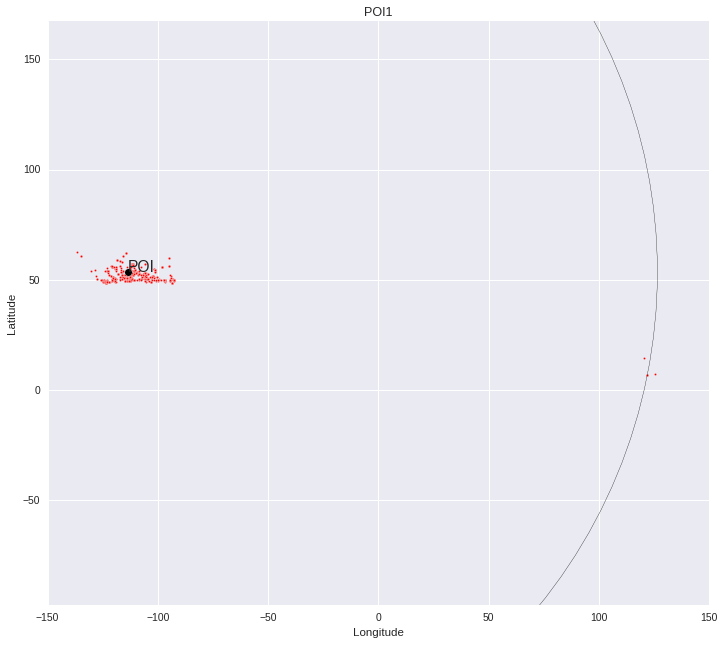

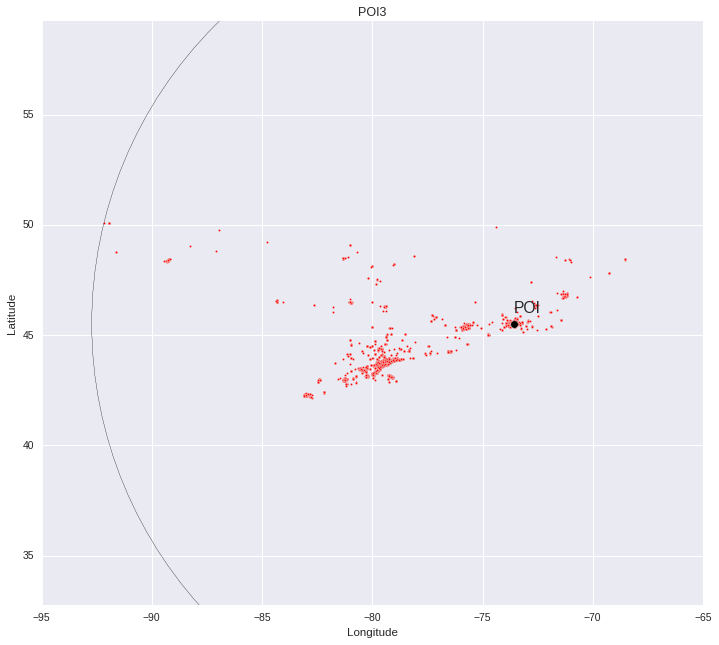

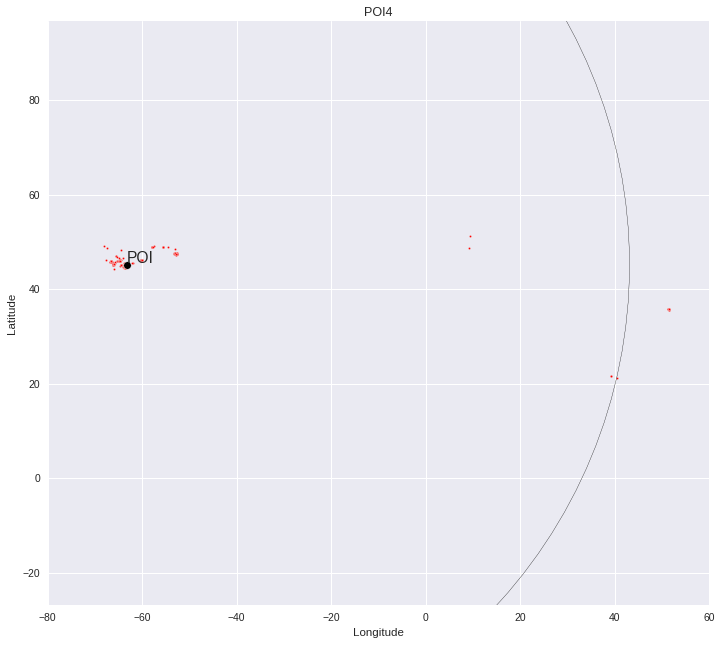

In [452]:
def get_poi_coordinates(poi_id: str) -> tuple(float):
    """
    Returns the coordinates of the POI with the given <poi_id>
    The tuple returned will be formatted as (longitude, latitude)
    """
    df = pd.read_csv('./data/POIList.csv')
    poi = df[df['POIID'] == poi_id]
    
    return (poi['Longitude'], poi[' Latitude'])


def get_circle_radius(poi: str) -> float:
    """Calculate the radius of the circle for the given <poi>"""
    df = pd.read_csv('./data/FilteredDataSample.csv')
    
    # Get requests associated with the given <poi> and find the coordinates of the furthest point
    poi_requests = df[df['ClosestPOI'] == poi]
    furthest_index = poi_requests[['POIDistance']].idxmax()
    furthest_point = df.loc[furthest_index]
    
    longitude, latitude = furthest_point['Longitude'], furthest_point['Latitude']
    
    # Get POI coordinates before calculating distance
    poi_coords = get_poi_coordinates(poi)
    
    # Calculate distance between POI and furthest point
    radius = math.dist((longitude, latitude), (poi_coords))
    
    return radius
    

def plot_data(req_longitudes: array[float], req_latitudes: array[float], poi: str) -> None:
    """Plot the data associated with the given <poi>"""
    # Get POI location and plot it
    poi_longitude, poi_latitude = get_poi_coordinates(poi)
    plt.figure(figsize=(9, 9), dpi=75)
    plt.scatter(poi_longitude, poi_latitude, c='black', s=50, zorder=2)
    plt.text(poi_longitude, poi_latitude + .5, 'POI', size=15)
    
    # Plot requests data
    plt.scatter(req_longitudes, req_latitudes, c='r', s=4)
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    
    
    plt.style.use('seaborn')
    plt.title(poi)
    plt.axis('equal')
    
    # Plot Circle surrounding POI and its requests
    radius = get_circle_radius(poi)
    poi_circle = plt.Circle((poi_longitude, poi_latitude), radius, color='black', fill=False)
    plt.gca().add_patch(poi_circle)
    
    plt.show()
    
     
df = pd.read_csv('./data/FilteredDataSample.csv')
poi_groups = df.groupby(['ClosestPOI'])

# Get results data on each POI and plot it
for group in poi_groups.groups:
    req_longitudes = poi_groups.get_group(group)['Longitude']
    req_latitudes = poi_groups.get_group(group)['Latitude']
    
    plot_data(req_longitudes, req_latitudes, group)


### NOTE: Some points may appear to be out of the circle but this is due to the spherical nature of earth so the distance from the opposing direction is closer but I couldn't show this on a 2D map